In [1]:
import sklearn
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 

In [3]:
train_data = pd.read_csv('data/train.csv')
train_data

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [4]:
train_data_prepared = pd.get_dummies(train_data, prefix=['ho_'], columns = ['Home Ownership'], drop_first=False)

In [5]:
train_data_prepared['Annual Income'] = train_data_prepared['Annual Income'].fillna(train_data_prepared['Annual Income'].median())

In [6]:
transform_dict = {'< 1 year':0.5, '10+ years':10, '2 years':2, '3 years':3, '5 years':5, '1 year':1, '4 years':4, '6 years':6, '7 years':7, '8 years':8, '9 years':9}

train_data_prepared['Years in current job'] = train_data_prepared['Years in current job'].replace(transform_dict, None)
train_data_prepared['Years in current job'] = train_data_prepared['Years in current job'].fillna(0)

In [7]:
del train_data_prepared['Months since last delinquent']

In [8]:
train_data_prepared['Bankruptcies'] = train_data_prepared['Bankruptcies'].fillna(train_data_prepared['Number of Credit Problems'].apply(lambda x: 0 if (x == 0) else 1))

In [9]:
train_data_prepared = pd.get_dummies(train_data_prepared, prefix=['p_'], columns = ['Purpose'], drop_first=False)

In [10]:
transform_dict = {'Long Term':0, 'Short Term':1}
train_data_prepared['Term'] = train_data_prepared['Term'].replace(transform_dict, None)

In [11]:
current_loan_amount_nan = train_data_prepared['Current Loan Amount'].replace(99999999, np.nan)
train_data_prepared['Current Loan Amount'] = current_loan_amount_nan.fillna(current_loan_amount_nan.median())


In [12]:
train_data_prepared['Credit Score'] = train_data_prepared['Credit Score'].apply(lambda x: x/10 if x>1000 else x)
train_data_prepared['Credit Score'] = train_data_prepared['Credit Score'].fillna(train_data_prepared['Credit Score'].median())

In [13]:
train_data_prepared

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,...,p__home improvements,p__major purchase,p__medical bills,p__moving,p__other,p__renewable energy,p__small business,p__take a trip,p__vacation,p__wedding
0,482087.0,0.0,0.0,11.0,26.3,685960.0,1.0,1.0,1,265826.0,...,0,0,0,0,0,0,0,0,0,0
1,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,0.0,0,264968.0,...,0,0,0,0,0,0,0,0,0,0
2,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,0.0,1,265826.0,...,0,0,0,0,0,0,0,0,0,0
3,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,1.0,1,121396.0,...,0,0,0,0,0,0,0,0,0,0
4,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,0.0,1,125840.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,0.5,0.0,3.0,8.5,107866.0,0.0,0.0,1,129360.0,...,0,0,0,0,1,0,0,0,0,0
7496,1533984.0,1.0,0.0,10.0,26.5,686312.0,0.0,0.0,0,444048.0,...,0,0,0,0,0,0,0,0,0,0
7497,1878910.0,6.0,0.0,12.0,32.1,1778920.0,0.0,0.0,1,265826.0,...,0,0,0,0,0,0,0,0,0,0
7498,1168386.0,0.0,0.0,21.0,26.5,1141250.0,0.0,0.0,1,615274.0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

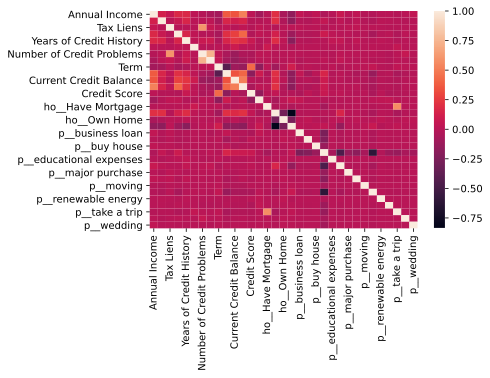

In [14]:
sns.heatmap(train_data_prepared.corr())

## Обучение

In [73]:
target = 'Credit Default'

In [74]:
X = np.array(train_data_prepared.iloc[:, train_data_prepared.columns != target])

In [75]:
y = train_data_prepared[target].astype(int)

In [88]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [89]:
dtest = xgb.DMatrix(X_test)

In [90]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=0.20, random_state=1)

In [27]:
import xgboost as xgb

In [119]:
xgb.cv(param, dtrain, 10, nfold=5,
       metrics={'auc'}, seed=0,
       callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

[0]	train-auc:0.72163+0.00871	test-auc:0.65106+0.01136
[1]	train-auc:0.75433+0.00505	test-auc:0.66819+0.00809
[2]	train-auc:0.77668+0.00240	test-auc:0.67650+0.01029
[3]	train-auc:0.79250+0.00230	test-auc:0.67937+0.00649
[4]	train-auc:0.80500+0.00279	test-auc:0.67967+0.00751
[5]	train-auc:0.81738+0.00226	test-auc:0.67954+0.00400
[6]	train-auc:0.82745+0.00223	test-auc:0.67431+0.00519
[7]	train-auc:0.83627+0.00434	test-auc:0.67775+0.00341
[8]	train-auc:0.84385+0.00378	test-auc:0.67725+0.00250
[9]	train-auc:0.85049+0.00265	test-auc:0.67725+0.00182


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.721633,0.008709,0.651063,0.011363
1,0.754334,0.005053,0.668190,0.008093
2,0.776679,0.002396,0.676503,0.010291
3,0.792496,0.002301,0.679366,0.006489
4,0.805000,0.002787,0.679673,0.007510
5,0.817377,0.002255,0.679544,0.004002
6,0.827451,0.002231,0.674309,0.005194
7,0.836271,0.004337,0.677750,0.003409
8,0.843850,0.003778,0.677252,0.002504
9,0.850490,0.002647,0.677253,0.001818


In [120]:
param = {'max_depth': 3, 'eta': 0.33, 'objective': 'binary:logistic'}
param['eval_metric'] = 'auc'
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_validation, label=y_validation)

evallist = [(dvalidation, 'eval'), (dtrain, 'train')]


bst = xgb.train(param, dtrain, 300, evallist, early_stopping_rounds=10)
bst.save_model('0001.model')


[0]	eval-auc:0.64761	train-auc:0.65002
[1]	eval-auc:0.69553	train-auc:0.69263
[2]	eval-auc:0.70429	train-auc:0.70093
[3]	eval-auc:0.71330	train-auc:0.71226
[4]	eval-auc:0.71551	train-auc:0.72075
[5]	eval-auc:0.71598	train-auc:0.72737
[6]	eval-auc:0.71905	train-auc:0.73426
[7]	eval-auc:0.72064	train-auc:0.74389
[8]	eval-auc:0.71947	train-auc:0.75031
[9]	eval-auc:0.71833	train-auc:0.75623
[10]	eval-auc:0.72064	train-auc:0.75928
[11]	eval-auc:0.72079	train-auc:0.76067
[12]	eval-auc:0.72072	train-auc:0.76272
[13]	eval-auc:0.72283	train-auc:0.76576
[14]	eval-auc:0.72223	train-auc:0.76860
[15]	eval-auc:0.72265	train-auc:0.77257
[16]	eval-auc:0.72239	train-auc:0.77675
[17]	eval-auc:0.72145	train-auc:0.77824
[18]	eval-auc:0.72522	train-auc:0.78152
[19]	eval-auc:0.72553	train-auc:0.78214
[20]	eval-auc:0.72495	train-auc:0.78605
[21]	eval-auc:0.72512	train-auc:0.78940
[22]	eval-auc:0.72622	train-auc:0.79220
[23]	eval-auc:0.72636	train-auc:0.79435
[24]	eval-auc:0.72619	train-auc:0.79739
[25]	eval-

[203]	eval-auc:0.71613	train-auc:0.95441
[204]	eval-auc:0.71620	train-auc:0.95439
[205]	eval-auc:0.71507	train-auc:0.95542
[206]	eval-auc:0.71514	train-auc:0.95549
[207]	eval-auc:0.71658	train-auc:0.95585
[208]	eval-auc:0.71661	train-auc:0.95649
[209]	eval-auc:0.71668	train-auc:0.95662
[210]	eval-auc:0.71686	train-auc:0.95673
[211]	eval-auc:0.71695	train-auc:0.95672
[212]	eval-auc:0.71675	train-auc:0.95674
[213]	eval-auc:0.71634	train-auc:0.95686
[214]	eval-auc:0.71560	train-auc:0.95726
[215]	eval-auc:0.71533	train-auc:0.95768
[216]	eval-auc:0.71453	train-auc:0.95802
[217]	eval-auc:0.71430	train-auc:0.95872
[218]	eval-auc:0.71290	train-auc:0.95948
[219]	eval-auc:0.71253	train-auc:0.95943
[220]	eval-auc:0.71258	train-auc:0.95995
[221]	eval-auc:0.71304	train-auc:0.96041
[222]	eval-auc:0.71280	train-auc:0.96061
[223]	eval-auc:0.71274	train-auc:0.96103
[224]	eval-auc:0.71286	train-auc:0.96118
[225]	eval-auc:0.71302	train-auc:0.96096
[226]	eval-auc:0.71219	train-auc:0.96156
[227]	eval-auc:0

In [121]:
ypred = bst.predict(dtest, iteration_range=(0, bst.best_iteration))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

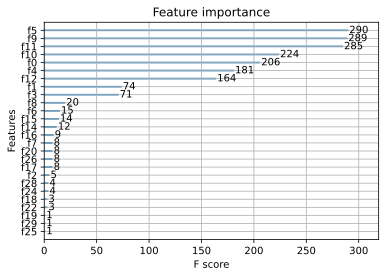

In [122]:
xgb.plot_importance(bst)

In [123]:
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in ypred]
print(f1_score(y_test, predictions, average='binary'))
print(roc_auc_score(predictions, y_test))
print(confusion_matrix(predictions, y_test))
print(accuracy_score(predictions, y_test))

0.329803328290469
0.6045858914088614
[[948 314]
 [129 109]]
0.7046666666666667


0.36484687083888157
0.5868278115375011
[[886 286]
 [191 137]]
0.682


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# Загружаем алгоритмы модели
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# оцениваем модель на каждой итерации
results = []
names = []

for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.034199 (0.014163)
LDA: 0.204773 (0.019136)
KNN: 0.274118 (0.028213)
CART: 0.368962 (0.031772)
NB: 0.442305 (0.005810)
SVM: 0.000000 (0.000000)


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [37]:
%%time
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(solver="warn"), parameters)
grid_search.fit(x_train, y_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got warn.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\git\project2\ml\lib\site-packages\sklearn\model_se

D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\git\project2\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\git\project2\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got warn.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\git\project2\ml\lib\site-packages\sklearn\model_se

ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got warn.

In [101]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
def dummy_score(strategy_):
    clf_dummy = DummyClassifier(strategy = strategy_)
    clf_dummy.fit(X_train, y_train)
    ypred = clf_dummy.predict(X_test)
    print(f'{strategy_}:')
    print(f'f1_score: {f1_score(y_test, ypred, average="binary")}')
    print(f'roc_auc: {roc_auc_score(ypred, y_test)}')
    print(confusion_matrix(ypred, y_test))
    print()

dummy_score('uniform')
dummy_score('stratified')

uniform:
f1_score: 0.356839422259983
roc_auc: 0.49649590032783153
[[533 213]
 [544 210]]

stratified:
f1_score: 0.2602409638554217
roc_auc: 0.4885793220651409
[[778 315]
 [299 108]]



In [99]:
clf_dummy.fit(X_train, y_train)
ypred = clf_dummy.predict(X_test)

In [100]:
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in ypred]
print(f1_score(y_test, predictions, average='binary'))
print(roc_auc_score(predictions, y_test))
print(confusion_matrix(predictions, y_test))
print(accuracy_score(predictions, y_test))

0.0


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, verbose=1)
rf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.2s finished


RandomForestClassifier(n_estimators=1000, verbose=1)

In [43]:
ypred = rf.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [45]:
ypred.T

array([1, 1, 1, ..., 1, 1, 1])

In [83]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score